<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/Fractal3_Assignment/Major_Project_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


import torch.nn.functional as F
import torch.optim as optim
import math
import albumentations as A
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
# Transforming train and test dataset

transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    transforms.RandomErasing(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

In [4]:
# Downloading the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

## Visualising Images : 

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
4


In [7]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 # denormalising the image
    plt.figure(figsize=(batch_size*20, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [8]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images) # puts together images to form a bigger image
    imshow(img, title=[trainset.classes[x.item()] for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


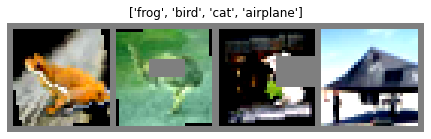

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


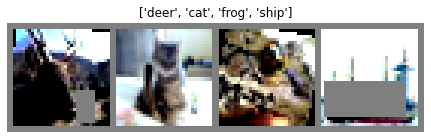

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


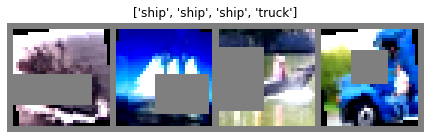

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


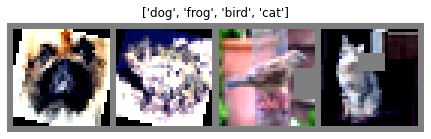

In [9]:
for i in range(4):
    show_batch_images(trainloader)

## Custom Model Architecture

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 32 , 32]

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 30 , 30]

        # pooling layer
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = [N , 48 , 15 , 15]

        self.convblock3 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 15 , 15]

        self.convblock4 = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 13 , 13]

        # pooling layer
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = [N , 96 , 6 , 6]

        self.convblock5 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU()
        ) # output_size = [N , 192 , 6 , 6]

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = [N , 192 , 4 , 4]

        self.fc_model = nn.Sequential(
            nn.Linear(3072*2,512),         # (N, 3072*2) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,512),             # (N, 512) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,256),          # (N, 512) -> (N, 256)
            nn.Linear(256,10)            # (N, 256)  -> (N, 10)
        )
      

    def forward(self, x):
        img = copy.deepcopy(x)
               
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)

        x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
        
        #Skip connection feeding input image directly into Fully connected layers
        x = torch.cat((x,img.reshape(x.size(0),-1)),dim = 1)
        
        x = self.fc_model(x)

        return F.log_softmax(x, dim=-1)


In [11]:
from torchsummary import summary
net = Net().to(device)
print(summary(net, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 30, 30]          20,736
       BatchNorm2d-5           [-1, 48, 30, 30]              96
              ReLU-6           [-1, 48, 30, 30]               0
         MaxPool2d-7           [-1, 48, 15, 15]               0
           Dropout-8           [-1, 48, 15, 15]               0
            Conv2d-9           [-1, 96, 15, 15]          41,472
      BatchNorm2d-10           [-1, 96, 15, 15]             192
             ReLU-11           [-1, 96, 15, 15]               0
           Conv2d-12           [-1, 96, 13, 13]          82,944
      BatchNorm2d-13           [-1, 96, 13, 13]             192
             ReLU-14           [-1, 96,

## Train CIFAR10 (CNN + MLP)

In [12]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [13]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [14]:
# Initialise and move model to Cuda
net = Net().to(device)

#this takes into consideration that we have to differentiate through softmax layer, given softmax is not applied in our vgg
loss_fn = nn.CrossEntropyLoss() 
opt = optim.SGD(net.parameters(), lr=0.01,momentum = 0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(trainloader)*10, gamma=0.01)


In [15]:
# Training Loop

loss_epoch_arr_CNN_MLP = []
max_epochs = 150
train_acc_CNN_MLP = []
val_acc_CNN_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 1.28
Epoch: 1/150, Test acc: 53.38, Train acc: 51.12
Iteration: 0/782, Loss: 1.28
Iteration: 500/782, Loss: 1.03
Epoch: 2/150, Test acc: 63.01, Train acc: 60.66
Iteration: 0/782, Loss: 1.41
Iteration: 500/782, Loss: 0.99
Epoch: 3/150, Test acc: 65.81, Train acc: 62.98
Iteration: 0/782, Loss: 1.13
Iteration: 500/782, Loss: 0.76
Epoch: 4/150, Test acc: 70.14, Train acc: 66.98
Iteration: 0/782, Loss: 1.12
Iteration: 500/782, Loss: 0.92
Epoch: 5/150, Test acc: 71.41, Train acc: 68.89
Iteration: 0/782, Loss: 0.88
Iteration: 500/782, Loss: 1.02
Epoch: 6/150, Test acc: 73.66, Train acc: 70.91
Iteration: 0/782, Loss: 0.65
Iteration: 500/782, Loss: 0.59
Epoch: 7/150, Test acc: 74.51, Train acc: 71.63
Iteration: 0/782, Loss: 0.75
Iteration: 500/782, Loss: 0.85
Epoch: 8/150, Test acc: 76.13, Train acc: 73.53
Iteration: 0/782, Loss: 0.96
Iteration: 500/782, Loss: 0.56
Epoch: 9/150, Test acc: 76.72, Train acc: 73.75
Iteration: 0/782, Loss: 0.59

## Training Last 10 epochs without Random Eraser

In [16]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
max_epochs = 10

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))


Iteration: 0/782, Loss: 0.18
Iteration: 500/782, Loss: 0.06
Epoch: 1/10, Test acc: 85.01, Train acc: 97.57
Iteration: 0/782, Loss: 0.03
Iteration: 500/782, Loss: 0.04
Epoch: 2/10, Test acc: 84.82, Train acc: 97.74
Iteration: 0/782, Loss: 0.03
Iteration: 500/782, Loss: 0.21
Epoch: 3/10, Test acc: 84.93, Train acc: 97.52
Iteration: 0/782, Loss: 0.25
Iteration: 500/782, Loss: 0.08
Epoch: 4/10, Test acc: 84.37, Train acc: 97.57
Iteration: 0/782, Loss: 0.11
Iteration: 500/782, Loss: 0.16
Epoch: 5/10, Test acc: 84.63, Train acc: 97.68
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.10
Epoch: 6/10, Test acc: 85.08, Train acc: 97.82
Iteration: 0/782, Loss: 0.01
Iteration: 500/782, Loss: 0.02
Epoch: 7/10, Test acc: 84.32, Train acc: 97.76
Iteration: 0/782, Loss: 0.00
Iteration: 500/782, Loss: 0.06
Epoch: 8/10, Test acc: 84.70, Train acc: 97.60
Iteration: 0/782, Loss: 0.05
Iteration: 500/782, Loss: 0.04
Epoch: 9/10, Test acc: 84.97, Train acc: 97.86
Iteration: 0/782, Loss: 0.01
Iteratio

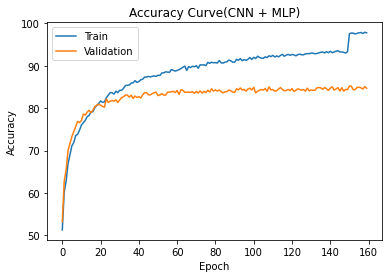

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_CNN_MLP,label='Train')
ax.plot(val_acc_CNN_MLP, label='Validation')

plt.title("Accuracy Curve(CNN + MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

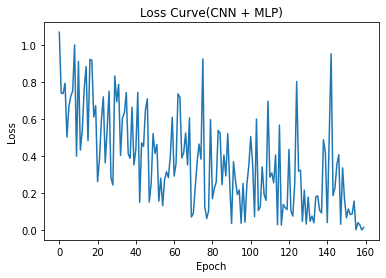

In [19]:
plt.plot(loss_epoch_arr_CNN_MLP)
plt.title("Loss Curve(CNN + MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#Testing Model on a random image

In [23]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle=True)
for data in testloader:
  image , label = data
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


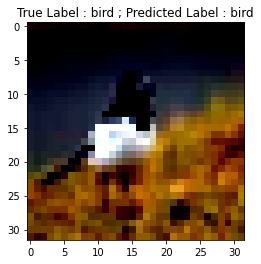

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


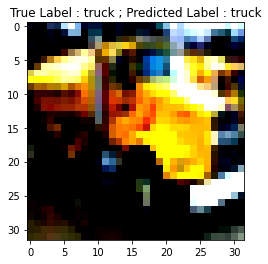

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


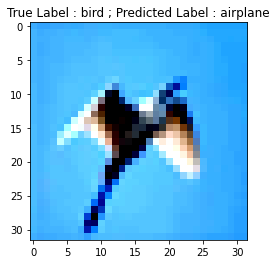

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


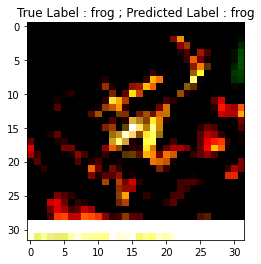

In [24]:
net = net.to('cpu')
for img , label in zip(image , label):
  _,prediction = torch.max(net(img.unsqueeze(0)).data,1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True Label : {trainset.classes[label.item()]} ; Predicted Label : {trainset.classes[prediction]}")
  plt.show()

## Train CIFAR10 (MLP)

In [3]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [4]:
#pca = PCA()
pca_result = x_train

In [5]:
PCA_train = x_train
PCA_test = x_test

In [6]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [7]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [10]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(3072,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [11]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [12]:
from torchsummary import summary
print(summary(net, (1,3072)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       1,573,376
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 512]         262,656
              ReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
            Linear-8                [-1, 1, 10]           2,570
Total params: 1,969,930
Trainable params: 1,969,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 7.51
Estimated Total Size (MB): 7.55
----------------------------------------------------------------
None


In [13]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [14]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [16]:
# Training Loop

loss_epoch_arr_MLP = []
max_epochs = 150
train_acc_MLP = []
val_acc_MLP = []
batch_size = 64

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_MLP.append(loss.item())
    train_acc_MLP.append(evaluation(trainloader, net))
    val_acc_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.29
Iteration: 500/782, Loss: 2.11
Epoch: 1/150, Test acc: 25.59, Train acc: 25.22
Iteration: 0/782, Loss: 2.10
Iteration: 500/782, Loss: 2.00
Epoch: 2/150, Test acc: 29.97, Train acc: 30.57
Iteration: 0/782, Loss: 2.00
Iteration: 500/782, Loss: 1.94
Epoch: 3/150, Test acc: 33.89, Train acc: 34.14
Iteration: 0/782, Loss: 1.86
Iteration: 500/782, Loss: 1.80
Epoch: 4/150, Test acc: 36.05, Train acc: 36.36
Iteration: 0/782, Loss: 1.76
Iteration: 500/782, Loss: 1.84
Epoch: 5/150, Test acc: 37.59, Train acc: 37.49
Iteration: 0/782, Loss: 1.77
Iteration: 500/782, Loss: 1.75
Epoch: 6/150, Test acc: 38.94, Train acc: 38.96
Iteration: 0/782, Loss: 1.74
Iteration: 500/782, Loss: 1.70
Epoch: 7/150, Test acc: 40.39, Train acc: 40.69
Iteration: 0/782, Loss: 1.67
Iteration: 500/782, Loss: 1.71
Epoch: 8/150, Test acc: 40.99, Train acc: 41.21
Iteration: 0/782, Loss: 1.66
Iteration: 500/782, Loss: 1.73
Epoch: 9/150, Test acc: 41.45, Train acc: 41.69
Iteration: 0/782, Loss: 1.63

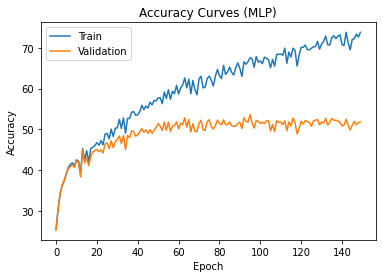

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='Train')
ax.plot(val_acc_MLP, label='Validation')

plt.title("Accuracy Curves (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

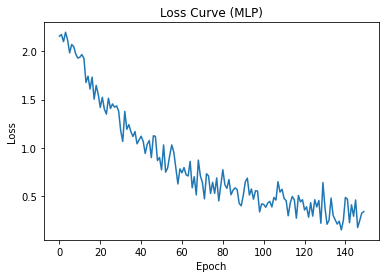

In [18]:
plt.plot(loss_epoch_arr_MLP)
plt.title("Loss Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [22]:
train_acc_MLP

[25.344,
 30.36,
 34.258,
 36.206,
 37.358,
 38.902,
 40.616,
 41.378,
 41.744,
 41.044,
 42.492,
 42.176,
 39.022,
 45.256,
 42.436,
 44.746,
 41.95,
 45.298,
 45.564,
 46.01,
 46.73,
 46.09,
 47.22,
 46.178,
 48.802,
 48.99,
 47.656,
 50.034,
 48.236,
 50.264,
 50.376,
 52.436,
 50.23,
 52.794,
 49.066,
 52.652,
 52.672,
 54.2,
 54.366,
 53.438,
 53.572,
 54.344,
 55.9,
 54.838,
 55.738,
 55.222,
 56.652,
 56.008,
 57.1,
 56.966,
 57.718,
 57.762,
 56.294,
 59.154,
 57.588,
 59.7,
 57.394,
 59.358,
 58.77,
 60.804,
 58.724,
 60.188,
 60.898,
 62.634,
 60.184,
 62.314,
 58.758,
 61.996,
 59.772,
 58.488,
 62.42,
 63.04,
 60.178,
 60.408,
 62.476,
 63.062,
 62.062,
 60.62,
 63.076,
 64.706,
 63.192,
 62.468,
 65.728,
 63.484,
 64.174,
 65.286,
 63.984,
 63.368,
 65.164,
 66.334,
 64.936,
 63.04,
 66.592,
 65.992,
 66.658,
 67.596,
 67.296,
 65.25,
 67.89,
 66.506,
 66.806,
 66.122,
 67.728,
 67.476,
 67.092,
 65.14,
 67.162,
 65.528,
 68.374,
 68.448,
 68.488,
 68.2,
 69.962,
 66.234,


In [34]:
val_acc_MLP

[25.28,
 30.27,
 34.0,
 36.22,
 37.52,
 39.19,
 40.34,
 40.84,
 41.23,
 40.66,
 42.29,
 41.84,
 38.3,
 44.94,
 41.72,
 43.0,
 41.06,
 43.38,
 44.41,
 44.8,
 45.04,
 44.52,
 44.94,
 44.21,
 46.35,
 46.69,
 45.25,
 47.18,
 45.5,
 46.95,
 47.48,
 48.36,
 46.55,
 48.42,
 45.03,
 48.52,
 47.92,
 49.61,
 49.48,
 48.3,
 48.66,
 49.38,
 50.17,
 49.28,
 49.83,
 49.02,
 49.91,
 49.05,
 49.7,
 50.52,
 51.39,
 50.74,
 49.71,
 51.76,
 49.75,
 51.73,
 49.51,
 50.81,
 50.89,
 51.83,
 50.1,
 51.49,
 51.19,
 52.84,
 50.55,
 52.39,
 49.37,
 51.38,
 49.54,
 49.39,
 51.5,
 52.23,
 49.91,
 49.74,
 51.9,
 52.36,
 50.63,
 50.07,
 50.93,
 52.23,
 51.5,
 51.11,
 52.33,
 51.12,
 51.18,
 51.79,
 50.87,
 50.74,
 50.8,
 51.43,
 51.71,
 50.22,
 52.82,
 51.99,
 51.76,
 53.61,
 51.52,
 50.32,
 52.18,
 51.99,
 51.47,
 51.72,
 51.45,
 52.1,
 52.04,
 49.61,
 51.19,
 49.44,
 52.14,
 51.68,
 51.8,
 51.16,
 52.1,
 49.65,
 51.83,
 50.89,
 52.78,
 51.65,
 48.87,
 50.26,
 52.01,
 51.32,
 52.19,
 51.85,
 51.71,
 50.75,
 52.04,

In [33]:
max(val_acc_MLP)

53.61

In [24]:
loss_epoch_arr_MLP

[2.1579794883728027,
 2.175133228302002,
 2.1019036769866943,
 2.1992578506469727,
 2.11862850189209,
 1.9853241443634033,
 2.071876287460327,
 2.0505623817443848,
 1.97244131565094,
 1.9308431148529053,
 1.9401252269744873,
 1.9677817821502686,
 1.92668616771698,
 1.6781007051467896,
 1.7431690692901611,
 1.6098480224609375,
 1.7329986095428467,
 1.5043123960494995,
 1.6476175785064697,
 1.5553251504898071,
 1.4186766147613525,
 1.5240365266799927,
 1.400770664215088,
 1.349429965019226,
 1.5143885612487793,
 1.408050775527954,
 1.4549782276153564,
 1.4220949411392212,
 1.4346333742141724,
 1.3792895078659058,
 1.1772847175598145,
 1.065626859664917,
 1.3779383897781372,
 1.1919467449188232,
 1.2403802871704102,
 1.1654940843582153,
 1.1172065734863281,
 1.1680290699005127,
 1.041022539138794,
 1.0822200775146484,
 1.1197186708450317,
 1.0673797130584717,
 0.9414706230163574,
 1.037027359008789,
 1.075132966041565,
 0.8979967832565308,
 1.1247117519378662,
 1.1179343461990356,
 0.8672

## Train CIFAR10 PCA (90 % Variance ) + MLP

In [19]:
#Reducing dimension to represent 90% variance of dataset
pca = PCA(0.9)
pca_result = pca.fit(x_train)

In [20]:
pca.n_components_

99

In [21]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [25]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [26]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [27]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [28]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=99, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [29]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]          51,200
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 512]         262,656
              ReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
            Linear-8                [-1, 1, 10]           2,570
Total params: 447,754
Trainable params: 447,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.71
Estimated Total Size (MB): 1.73
----------------------------------------------------------------
None


In [30]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [31]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [32]:
# Training Loop

loss_epoch_arr_PCA_90_MLP = []
max_epochs = 150
train_acc_PCA_90_MLP = []
val_acc_PCA_90_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_90_MLP.append(loss.item())
    train_acc_PCA_90_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_90_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 2.11
Epoch: 1/150, Test acc: 30.48, Train acc: 30.50
Iteration: 0/782, Loss: 2.06
Iteration: 500/782, Loss: 1.93
Epoch: 2/150, Test acc: 36.30, Train acc: 35.66
Iteration: 0/782, Loss: 1.87
Iteration: 500/782, Loss: 1.88
Epoch: 3/150, Test acc: 38.76, Train acc: 38.40
Iteration: 0/782, Loss: 1.73
Iteration: 500/782, Loss: 1.80
Epoch: 4/150, Test acc: 40.66, Train acc: 40.34
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.70
Epoch: 5/150, Test acc: 42.03, Train acc: 42.24
Iteration: 0/782, Loss: 1.68
Iteration: 500/782, Loss: 1.69
Epoch: 6/150, Test acc: 43.10, Train acc: 43.22
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.67
Epoch: 7/150, Test acc: 44.05, Train acc: 44.35
Iteration: 0/782, Loss: 1.64
Iteration: 500/782, Loss: 1.62
Epoch: 8/150, Test acc: 45.31, Train acc: 45.25
Iteration: 0/782, Loss: 1.55
Iteration: 500/782, Loss: 1.63
Epoch: 9/150, Test acc: 46.09, Train acc: 46.17
Iteration: 0/782, Loss: 1.48

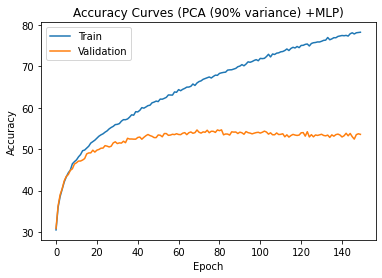

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_90_MLP,label='Train')
ax.plot(val_acc_PCA_90_MLP, label='Validation')

plt.title("Accuracy Curves (PCA (90% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [38]:
val_acc_PCA_90_MLP

[30.84,
 36.28,
 38.98,
 40.44,
 42.34,
 43.41,
 43.87,
 44.89,
 45.26,
 46.41,
 46.72,
 47.13,
 47.14,
 47.38,
 47.73,
 48.86,
 49.1,
 49.11,
 49.76,
 49.3,
 49.77,
 49.94,
 50.24,
 50.27,
 50.86,
 50.74,
 50.54,
 50.73,
 51.52,
 51.79,
 51.36,
 51.53,
 51.47,
 51.93,
 51.57,
 52.64,
 52.46,
 52.47,
 52.43,
 52.43,
 52.83,
 52.94,
 52.41,
 52.87,
 53.26,
 53.56,
 53.29,
 53.12,
 52.81,
 52.8,
 53.44,
 53.38,
 53.0,
 53.79,
 53.78,
 53.35,
 53.42,
 53.61,
 53.53,
 53.74,
 53.56,
 53.52,
 53.86,
 54.01,
 53.52,
 53.98,
 54.17,
 53.85,
 54.0,
 54.65,
 54.1,
 53.89,
 54.19,
 54.09,
 54.59,
 53.98,
 54.34,
 54.32,
 54.06,
 54.66,
 54.48,
 54.68,
 53.48,
 53.68,
 53.66,
 53.42,
 54.2,
 54.13,
 54.16,
 53.79,
 54.12,
 53.97,
 53.61,
 54.26,
 54.0,
 53.89,
 53.71,
 53.88,
 54.02,
 54.09,
 53.9,
 54.1,
 54.37,
 54.15,
 53.64,
 53.96,
 53.49,
 53.49,
 53.93,
 53.54,
 53.6,
 53.73,
 53.0,
 53.48,
 52.93,
 53.31,
 53.58,
 53.42,
 53.33,
 53.42,
 53.97,
 54.01,
 53.16,
 54.23,
 52.96,
 53.52,
 52.

In [39]:
train_acc_PCA_90_MLP

[30.482,
 35.94,
 38.562,
 40.266,
 42.06,
 43.294,
 44.28,
 44.964,
 46.47,
 46.984,
 47.412,
 48.148,
 48.704,
 49.63,
 49.796,
 50.25,
 50.726,
 51.478,
 51.846,
 52.184,
 52.648,
 53.146,
 53.472,
 53.724,
 54.118,
 54.432,
 54.914,
 55.256,
 55.524,
 55.948,
 56.008,
 56.194,
 56.782,
 57.142,
 57.13,
 57.308,
 57.75,
 58.318,
 58.224,
 59.068,
 59.014,
 59.398,
 60.05,
 59.926,
 60.21,
 60.532,
 60.64,
 61.218,
 61.388,
 61.632,
 61.514,
 62.118,
 62.09,
 62.298,
 62.542,
 63.122,
 63.088,
 63.08,
 63.85,
 63.762,
 64.406,
 64.144,
 64.48,
 64.706,
 65.008,
 65.026,
 65.212,
 65.766,
 65.418,
 66.012,
 66.358,
 66.53,
 66.896,
 67.094,
 67.314,
 67.466,
 67.216,
 67.594,
 67.906,
 67.864,
 68.324,
 68.468,
 68.572,
 68.63,
 69.126,
 69.186,
 69.21,
 69.39,
 69.548,
 69.942,
 70.1,
 70.456,
 70.168,
 70.582,
 71.122,
 71.02,
 71.2,
 71.468,
 71.656,
 71.39,
 71.958,
 71.902,
 71.972,
 72.396,
 72.952,
 72.314,
 73.022,
 72.906,
 73.222,
 73.306,
 73.548,
 73.624,
 73.864,
 74.238,

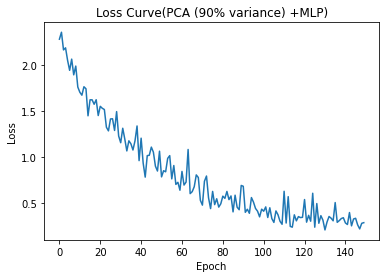

In [40]:
plt.plot(loss_epoch_arr_PCA_90_MLP)
plt.title("Loss Curve(PCA (90% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [41]:
loss_epoch_arr_PCA_90_MLP

[2.2800240516662598,
 2.3554704189300537,
 2.1633973121643066,
 2.18581485748291,
 2.0496909618377686,
 1.9411184787750244,
 2.063070058822632,
 1.892084002494812,
 1.987357497215271,
 1.7592285871505737,
 1.7025974988937378,
 1.670636534690857,
 1.762705683708191,
 1.740443229675293,
 1.4464737176895142,
 1.6203274726867676,
 1.6203980445861816,
 1.5720072984695435,
 1.6212671995162964,
 1.4493368864059448,
 1.5497325658798218,
 1.527930498123169,
 1.515038013458252,
 1.3221770524978638,
 1.2825411558151245,
 1.4120750427246094,
 1.4141638278961182,
 1.2869328260421753,
 1.4921531677246094,
 1.2267019748687744,
 1.1535146236419678,
 1.3110178709030151,
 1.193833351135254,
 1.0643672943115234,
 1.1745854616165161,
 1.1416324377059937,
 1.0743461847305298,
 1.1737935543060303,
 1.3358100652694702,
 0.9587796330451965,
 1.2029849290847778,
 0.9316433072090149,
 0.7793111205101013,
 1.0133042335510254,
 1.0169695615768433,
 1.1058486700057983,
 1.0509470701217651,
 0.8984982967376709,
 0.

## Train CIFAR10 PCA (95 % Variance ) + MLP

In [42]:
#Reducing dimension to represent 95% variance of dataset

pca = PCA(0.95)
pca_result = pca.fit(x_train)

In [43]:
pca.n_components_

217

In [44]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [45]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [46]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [47]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [48]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=217, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [49]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         111,616
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 512]         262,656
              ReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
            Linear-8                [-1, 1, 10]           2,570
Total params: 508,170
Trainable params: 508,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.94
Estimated Total Size (MB): 1.96
----------------------------------------------------------------
None


In [50]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [51]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [52]:
# Training Loop

loss_epoch_arr_PCA_95_MLP = []
max_epochs = 150
train_acc_PCA_95_MLP = []
val_acc_PCA_95_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_95_MLP.append(loss.item())
    train_acc_PCA_95_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_95_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 2.13
Epoch: 1/150, Test acc: 28.64, Train acc: 28.42
Iteration: 0/782, Loss: 2.07
Iteration: 500/782, Loss: 1.97
Epoch: 2/150, Test acc: 34.28, Train acc: 34.14
Iteration: 0/782, Loss: 1.94
Iteration: 500/782, Loss: 1.88
Epoch: 3/150, Test acc: 37.80, Train acc: 37.67
Iteration: 0/782, Loss: 1.76
Iteration: 500/782, Loss: 1.81
Epoch: 4/150, Test acc: 39.68, Train acc: 39.87
Iteration: 0/782, Loss: 1.67
Iteration: 500/782, Loss: 1.72
Epoch: 5/150, Test acc: 41.74, Train acc: 41.59
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.69
Epoch: 6/150, Test acc: 43.19, Train acc: 43.10
Iteration: 0/782, Loss: 1.64
Iteration: 500/782, Loss: 1.66
Epoch: 7/150, Test acc: 43.87, Train acc: 44.22
Iteration: 0/782, Loss: 1.65
Iteration: 500/782, Loss: 1.64
Epoch: 8/150, Test acc: 45.45, Train acc: 45.48
Iteration: 0/782, Loss: 1.55
Iteration: 500/782, Loss: 1.65
Epoch: 9/150, Test acc: 46.14, Train acc: 46.52
Iteration: 0/782, Loss: 1.55

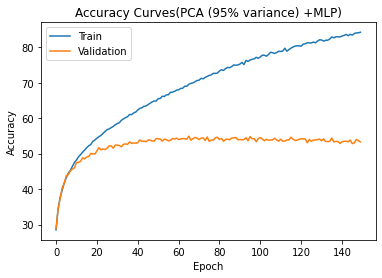

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_95_MLP,label='Train')
ax.plot(val_acc_PCA_95_MLP, label='Validation')

plt.title("Accuracy Curves(PCA (95% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

In [54]:
train_acc_PCA_95_MLP

[28.474,
 34.36,
 37.586,
 39.714,
 41.712,
 43.16,
 44.496,
 45.244,
 46.404,
 47.47,
 48.188,
 49.098,
 49.714,
 50.39,
 50.976,
 51.67,
 52.202,
 52.534,
 53.414,
 53.812,
 54.342,
 54.764,
 55.122,
 55.698,
 56.244,
 56.75,
 56.942,
 57.324,
 57.654,
 58.152,
 58.486,
 58.734,
 59.396,
 59.796,
 60.13,
 60.396,
 61.048,
 60.978,
 61.482,
 61.712,
 62.3,
 62.724,
 62.928,
 63.31,
 63.412,
 63.798,
 64.2,
 64.558,
 64.816,
 64.806,
 65.484,
 65.532,
 66.172,
 66.098,
 66.556,
 66.602,
 67.272,
 67.34,
 67.54,
 67.904,
 67.98,
 68.372,
 68.424,
 69.006,
 68.974,
 69.548,
 69.796,
 69.94,
 70.25,
 70.608,
 70.686,
 71.216,
 71.086,
 71.48,
 71.746,
 72.04,
 72.208,
 72.622,
 72.624,
 72.698,
 73.302,
 73.656,
 73.452,
 73.978,
 74.302,
 74.198,
 74.56,
 74.988,
 74.92,
 74.988,
 75.242,
 75.724,
 75.094,
 76.288,
 75.986,
 76.396,
 76.598,
 76.708,
 77.156,
 76.864,
 77.264,
 77.754,
 77.736,
 77.462,
 77.946,
 78.57,
 78.464,
 78.226,
 78.496,
 78.87,
 78.796,
 78.924,
 79.72,
 78.864

In [55]:
val_acc_PCA_95_MLP

[28.84,
 34.35,
 37.28,
 40.3,
 41.56,
 43.75,
 44.06,
 45.14,
 45.56,
 46.01,
 47.45,
 47.56,
 47.81,
 48.81,
 48.52,
 49.04,
 49.17,
 50.02,
 49.9,
 49.89,
 50.74,
 51.67,
 51.05,
 51.31,
 51.14,
 51.55,
 52.18,
 52.17,
 51.52,
 52.4,
 52.38,
 52.27,
 51.91,
 52.59,
 52.73,
 52.59,
 53.32,
 52.87,
 53.0,
 52.95,
 53.06,
 53.87,
 53.46,
 53.52,
 53.34,
 53.8,
 53.82,
 53.55,
 53.5,
 54.24,
 54.21,
 54.09,
 53.53,
 54.07,
 53.94,
 53.58,
 53.74,
 54.22,
 54.09,
 54.35,
 53.98,
 54.13,
 54.22,
 54.21,
 54.04,
 54.94,
 53.77,
 54.2,
 54.54,
 54.35,
 53.97,
 54.33,
 54.44,
 53.69,
 54.68,
 53.47,
 53.83,
 53.78,
 54.47,
 54.61,
 54.0,
 54.24,
 53.49,
 54.01,
 54.05,
 53.9,
 54.41,
 54.4,
 54.54,
 53.89,
 53.98,
 53.89,
 53.97,
 54.48,
 53.62,
 54.8,
 54.18,
 54.22,
 53.35,
 54.23,
 54.51,
 54.1,
 53.63,
 54.04,
 53.77,
 53.81,
 53.86,
 54.33,
 53.84,
 53.53,
 54.05,
 53.51,
 53.53,
 53.85,
 53.85,
 54.62,
 54.06,
 53.69,
 53.78,
 54.02,
 54.17,
 54.12,
 54.14,
 53.04,
 53.99,
 53.45,
 53.

In [56]:
max(val_acc_PCA_95_MLP)

54.94

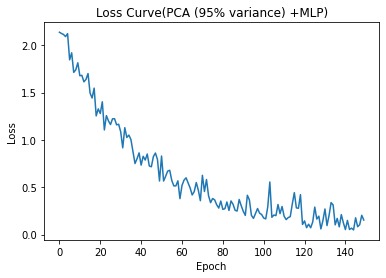

In [57]:
plt.plot(loss_epoch_arr_PCA_95_MLP)
plt.title("Loss Curve(PCA (95% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [58]:
loss_epoch_arr_PCA_95_MLP

[2.1383543014526367,
 2.125171661376953,
 2.1148691177368164,
 2.0926098823547363,
 2.123701810836792,
 1.846909523010254,
 1.920886516571045,
 1.7143844366073608,
 1.7409701347351074,
 1.815554141998291,
 1.679009199142456,
 1.6826398372650146,
 1.6142611503601074,
 1.6399140357971191,
 1.7019150257110596,
 1.4960565567016602,
 1.443336009979248,
 1.5478131771087646,
 1.2542431354522705,
 1.328282356262207,
 1.2795515060424805,
 1.4030131101608276,
 1.1056705713272095,
 1.257158637046814,
 1.2019696235656738,
 1.1628719568252563,
 1.223565936088562,
 1.223907709121704,
 1.1598330736160278,
 1.1661405563354492,
 1.0859758853912354,
 0.9167920351028442,
 1.1299892663955688,
 1.0265166759490967,
 1.0513315200805664,
 1.0050301551818848,
 0.8771487474441528,
 0.7509374618530273,
 0.8019396066665649,
 0.8634911775588989,
 0.7339935302734375,
 0.8274284601211548,
 0.7877749800682068,
 0.851502537727356,
 0.7249640226364136,
 0.7166454195976257,
 0.8241230249404907,
 0.8617040514945984,
 0.7

## Train CIFAR10  PCA (99 % Variance) + MLP

In [59]:
#Reducing dimension to represent 99% variance of dataset

pca = PCA(0.99)
pca_result = pca.fit(x_train)

In [60]:
pca.n_components_

658

In [61]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [62]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [63]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [64]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [65]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=658, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [66]:
from torchsummary import summary
print(summary(net, (1,pca.n_components_)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         337,408
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 512]         262,656
              ReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
            Linear-8                [-1, 1, 10]           2,570
Total params: 733,962
Trainable params: 733,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.80
Estimated Total Size (MB): 2.83
----------------------------------------------------------------
None


In [67]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [68]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [69]:
# Training Loop

loss_epoch_arr_PCA_99_MLP = []
max_epochs = 150
train_acc_PCA_99_MLP = []
val_acc_PCA_99_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_99_MLP.append(loss.item())
    train_acc_PCA_99_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_99_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.30
Iteration: 500/782, Loss: 2.19
Epoch: 1/150, Test acc: 26.94, Train acc: 26.09
Iteration: 0/782, Loss: 2.13
Iteration: 500/782, Loss: 2.06
Epoch: 2/150, Test acc: 31.61, Train acc: 31.71
Iteration: 0/782, Loss: 2.00
Iteration: 500/782, Loss: 1.95
Epoch: 3/150, Test acc: 36.62, Train acc: 36.16
Iteration: 0/782, Loss: 1.89
Iteration: 500/782, Loss: 1.87
Epoch: 4/150, Test acc: 39.21, Train acc: 38.74
Iteration: 0/782, Loss: 1.76
Iteration: 500/782, Loss: 1.75
Epoch: 5/150, Test acc: 41.14, Train acc: 40.78
Iteration: 0/782, Loss: 1.65
Iteration: 500/782, Loss: 1.78
Epoch: 6/150, Test acc: 42.27, Train acc: 42.66
Iteration: 0/782, Loss: 1.69
Iteration: 500/782, Loss: 1.77
Epoch: 7/150, Test acc: 43.87, Train acc: 44.28
Iteration: 0/782, Loss: 1.65
Iteration: 500/782, Loss: 1.75
Epoch: 8/150, Test acc: 44.70, Train acc: 45.62
Iteration: 0/782, Loss: 1.55
Iteration: 500/782, Loss: 1.67
Epoch: 9/150, Test acc: 46.24, Train acc: 47.07
Iteration: 0/782, Loss: 1.53

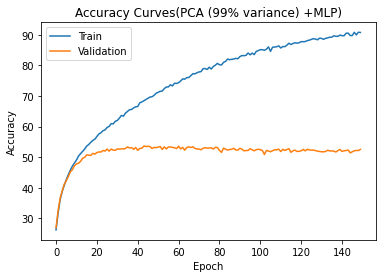

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_99_MLP,label='Train')
ax.plot(val_acc_PCA_99_MLP, label='Validation')

plt.title("Accuracy Curves(PCA (99% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

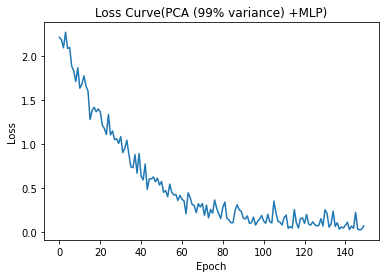

In [71]:
plt.plot(loss_epoch_arr_PCA_99_MLP)
plt.title("Loss Curve(PCA (99% variance) +MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train Accuracy PLot

In [72]:
train_acc_CNN_MLP = [51.308,
 60.246,
 62.766,
 66.882,
 68.97,
 71.126,
 71.878,
 73.562,
 73.826,
 74.824,
 76.0,
 76.588,
 77.136,
 77.99,
 78.276,
 79.13,
 79.138,
 80.15,
 80.594,
 81.088,
 81.684,
 81.384,
 81.46,
 82.434,
 83.04,
 83.654,
 83.628,
 83.308,
 84.004,
 83.65,
 84.204,
 84.21,
 84.68,
 85.324,
 85.386,
 85.444,
 85.914,
 85.972,
 86.474,
 86.06,
 86.264,
 86.688,
 86.806,
 87.324,
 87.318,
 87.47,
 87.366,
 87.482,
 87.608,
 87.468,
 87.764,
 87.694,
 88.282,
 88.324,
 88.55,
 88.504,
 88.436,
 89.1,
 88.898,
 88.732,
 88.882,
 89.08,
 89.328,
 89.618,
 89.912,
 88.884,
 89.788,
 89.548,
 89.874,
 89.724,
 90.012,
 89.382,
 90.206,
 90.166,
 90.206,
 90.02,
 90.774,
 90.554,
 90.82,
 90.68,
 90.72,
 90.616,
 91.212,
 90.668,
 90.616,
 90.832,
 90.916,
 91.32,
 91.15,
 90.846,
 90.806,
 91.498,
 91.27,
 91.678,
 91.172,
 91.452,
 91.266,
 91.504,
 91.932,
 91.468,
 91.976,
 91.666,
 92.228,
 91.966,
 91.774,
 91.722,
 92.09,
 91.91,
 92.336,
 92.138,
 92.438,
 92.052,
 92.31,
 92.084,
 92.43,
 92.668,
 92.214,
 92.5,
 92.672,
 92.436,
 92.65,
 92.558,
 92.32,
 92.598,
 92.714,
 92.574,
 92.566,
 92.77,
 92.844,
 92.836,
 92.966,
 92.938,
 92.804,
 92.874,
 93.004,
 93.16,
 93.23,
 92.996,
 93.298,
 93.054,
 93.396,
 93.072,
 93.216,
 93.434,
 93.51,
 93.234,
 93.232,
 93.142,
 92.978,
 93.31,
 97.552,
 97.69,
 97.672,
 97.474,
 97.622,
 97.74,
 97.82,
 97.586,
 97.88,
 97.738]

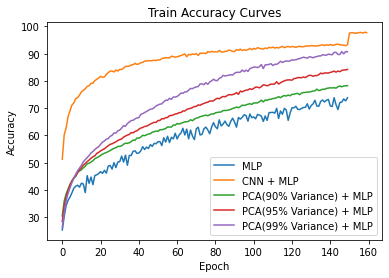

In [73]:
fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='MLP')
ax.plot(train_acc_CNN_MLP,label='CNN + MLP')
ax.plot(train_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(train_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(train_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Train Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Test Accuracy Plot

In [74]:
val_acc_CNN_MLP = [53.21,
 62.75,
 65.47,
 70.04,
 71.61,
 73.27,
 74.43,
 75.66,
 76.86,
 76.59,
 77.11,
 78.58,
 78.37,
 79.06,
 79.49,
 78.92,
 79.53,
 80.33,
 80.71,
 80.9,
 80.7,
 80.4,
 80.22,
 82.13,
 81.35,
 81.61,
 81.8,
 81.64,
 81.96,
 81.34,
 81.94,
 82.5,
 82.66,
 83.11,
 83.06,
 82.6,
 83.04,
 82.29,
 82.85,
 82.51,
 82.7,
 82.37,
 83.14,
 83.65,
 83.66,
 83.12,
 83.13,
 83.41,
 83.64,
 83.76,
 82.95,
 83.1,
 83.43,
 83.06,
 83.08,
 83.77,
 83.76,
 83.87,
 83.97,
 83.66,
 84.16,
 83.23,
 84.31,
 84.21,
 83.71,
 83.78,
 83.74,
 83.72,
 83.89,
 83.5,
 83.93,
 83.57,
 84.05,
 83.56,
 83.96,
 83.68,
 84.2,
 83.79,
 84.55,
 84.02,
 84.28,
 84.02,
 84.26,
 83.89,
 83.6,
 83.86,
 83.89,
 84.27,
 84.07,
 83.81,
 83.69,
 84.55,
 84.33,
 84.76,
 84.27,
 84.41,
 84.01,
 84.51,
 84.69,
 84.29,
 84.89,
 83.6,
 83.98,
 84.21,
 84.38,
 84.25,
 84.62,
 83.98,
 85.0,
 84.32,
 84.37,
 83.98,
 84.1,
 84.52,
 84.85,
 84.39,
 84.09,
 84.18,
 84.4,
 84.13,
 84.6,
 83.93,
 84.2,
 84.54,
 84.42,
 84.23,
 84.38,
 84.0,
 84.71,
 84.09,
 84.28,
 84.21,
 84.21,
 84.78,
 84.85,
 84.79,
 84.43,
 84.86,
 84.58,
 84.17,
 84.71,
 85.05,
 84.27,
 84.5,
 84.84,
 84.06,
 84.81,
 84.01,
 84.41,
 84.39,
 85.2,
 85.18,
 84.33,
 84.38,
 84.88,
 84.92,
 84.79,
 84.5,
 85.07,
 84.69]

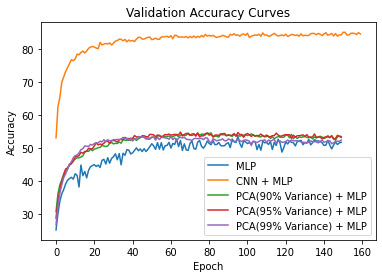

In [75]:
fig, ax = plt.subplots()

ax.plot(val_acc_MLP,label='MLP')
ax.plot(val_acc_CNN_MLP,label='CNN + MLP')
ax.plot(val_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(val_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(val_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Loss Curves

In [76]:
loss_epoch_arr_CNN_MLP = [1.070456862449646,
 0.7419290542602539,
 0.7385035157203674,
 0.7942847013473511,
 0.5035861134529114,
 0.6688485145568848,
 0.7241373658180237,
 0.7524973750114441,
 1.0022330284118652,
 0.40014520287513733,
 0.9127349257469177,
 0.4331335723400116,
 0.5404263734817505,
 0.762119472026825,
 0.8849634528160095,
 0.4833984375,
 0.9234429001808167,
 0.9191961288452148,
 0.611676037311554,
 0.6730920076370239,
 0.26282501220703125,
 0.3838680386543274,
 0.5958355069160461,
 0.7211748361587524,
 0.36370712518692017,
 0.5461297631263733,
 0.751544713973999,
 0.28278735280036926,
 0.24394488334655762,
 0.8334401249885559,
 0.6953400373458862,
 0.7887815237045288,
 0.40382903814315796,
 0.6075870394706726,
 0.6338983774185181,
 0.7441968321800232,
 0.4126707911491394,
 0.3884553015232086,
 0.6645413041114807,
 0.35225820541381836,
 0.43665575981140137,
 0.7450542449951172,
 0.1501682549715042,
 0.47193944454193115,
 0.4530881941318512,
 0.6506341695785522,
 0.7104873061180115,
 0.151677206158638,
 0.25437888503074646,
 0.5224640369415283,
 0.4147206246852875,
 0.4632536470890045,
 0.15681619942188263,
 0.28077462315559387,
 0.13153794407844543,
 0.2737717628479004,
 0.3159363567829132,
 0.28420042991638184,
 0.3996947407722473,
 0.6103782057762146,
 0.2924370765686035,
 0.3619663417339325,
 0.7371642589569092,
 0.7189117670059204,
 0.3906458616256714,
 0.4197395443916321,
 0.5257720351219177,
 0.3521997332572937,
 0.6073508262634277,
 0.0708707943558693,
 0.09058275818824768,
 0.22678440809249878,
 0.36778250336647034,
 0.46542835235595703,
 0.3840513527393341,
 0.9260982871055603,
 0.1263056844472885,
 0.06282825022935867,
 0.10362884402275085,
 0.5982875823974609,
 0.170289546251297,
 0.22680796682834625,
 0.2608738839626312,
 0.5391854047775269,
 0.5251064300537109,
 0.24559928476810455,
 0.4065897762775421,
 0.29287901520729065,
 0.5218129754066467,
 0.2608891427516937,
 0.036409392952919006,
 0.3701324462890625,
 0.27133864164352417,
 0.1922607272863388,
 0.21686185896396637,
 0.03689642623066902,
 0.2526763081550598,
 0.04301771521568298,
 0.24744567275047302,
 0.3483678698539734,
 0.5059752464294434,
 0.3575975000858307,
 0.07270534336566925,
 0.6007823944091797,
 0.106200210750103,
 0.12691356241703033,
 0.3413739800453186,
 0.19305498898029327,
 0.1608736217021942,
 0.6975956559181213,
 0.28701281547546387,
 0.30906665325164795,
 0.25668367743492126,
 0.40654394030570984,
 0.029369788244366646,
 0.5679919719696045,
 0.026847604662179947,
 0.13847950100898743,
 0.1214735135436058,
 0.11120229959487915,
 0.43651798367500305,
 0.10300352424383163,
 0.07597002387046814,
 0.25284072756767273,
 0.8037358522415161,
 0.31902608275413513,
 0.32384607195854187,
 0.046505529433488846,
 0.21626757085323334,
 0.03283335268497467,
 0.17864149808883667,
 0.047823790460824966,
 0.07556389272212982,
 0.03968144208192825,
 0.1803739070892334,
 0.18500012159347534,
 0.10623418539762497,
 0.09284728765487671,
 0.4889173209667206,
 0.4190169870853424,
 0.040443651378154755,
 0.4984971880912781,
 0.9544677734375,
 0.1868654489517212,
 0.2281443327665329,
 0.3543332815170288,
 0.40778517723083496,
 0.031592078506946564,
 0.3365757465362549,
 0.16647757589817047,
 0.0666433647274971,
 0.11468083411455154,
 0.08439894020557404,
 0.08722561597824097,
 0.1571829468011856,
 0.0024174281861633062,
 0.040521055459976196,
 0.028561823070049286,
 0.001086102332919836,
 0.014147964306175709]

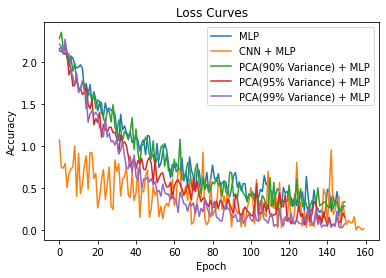

In [77]:
fig, ax = plt.subplots()

ax.plot(loss_epoch_arr_MLP,label='MLP')
ax.plot(loss_epoch_arr_CNN_MLP,label='CNN + MLP')
ax.plot(loss_epoch_arr_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")